# Original procedure outline

The original procedure consists from the following steps:

1. Constructing reference from bulk methylation dataset;
2. Intersection of sites from sc-methylation data with presented in the reference dataset;
3. Filtering the sites with good correlation between methylation and age;
4. Getting probabilities of each site to be methylated;
5. Truncating probabilites if needed;
6. Estimation maximum likelihood function for different values of ages (where ages are chosen from the uniform grid);
7. Finding the age value maximizing log-likelihood.

![](figures/procedure.png)

# Mathematical formulation

Problem of **single cell** age inference is reduced to the maximum likelihood estimation problem, namely:

$$ y^* = \argmax_y \prod_{i=1}^n p_i(y) \tag{1}$$

where $y$ - sought cell age and $y^*$ - optimal cell age correspondingy; $p_i(y)$ - probability of $i$-th CpG site to be methylated; $n$ - total number of sites. Authors proposed to use a concrete functional form for the probabilities:

$$ p_i(y) = p_i(y|b_i, w_i) = w_{i}y + b_i \tag{2}$$

the weight $w_i$ and bias $b_i$ are taken from a reference bulk dataset. Importantly these weights and biases are not the result of ElasticNet model fitting to predict age but Linear Regression model was fitted for each site separately. Specifically, for each $i$-th methylation site having methylation value $x_i \in [0,1]$ the following problem was solved:

$$ w_i,b_i = \argmin_{w, b} ||x_i - wy - b||_2^2$$

Thus, weights and biases, obtained after multiple regression models fitting on bulk dataset, were applied to predict cell age in the single cell dataset. Combining the equations (1) and (2) have:

$$ y^* = \argmax_y \prod_{i=1}^n (w_{i}y + b_i) \tag{3}$$

The objective (3) is not a whole procedure of cell age inference. Two problems have to be resolved before: 
1. Probability values are not bounded in the proposed linear function approximation;
2. The probabilites are not conditioned by the concrete single cell methylation profile.

For the first problem authors proposed to bound a linear function by a manually predetermined constants, e.g.:
\begin{align*} 
    if\ p \geq 1 \rightarrow p = 1 - \epsilon \\
    if\ p \leq 0 \rightarrow p = \epsilon 
\end{align*}
where $\epsilon$ is small constant typically equal to $0.001$. This bounding generates one of the main **problem** with the whole procedure which we discuss below in details within this notebook.

For the second problem authors proposed to use the following conditioning on single cell methylation profile for the probabilities by modifying equation (2):

$$ p_i(y) = p_i(y|b_i, w_i, CpG_i) = p_i^{CpG_i}(1-p_i)^{1-CpG_i} = 
\begin{bmatrix}
w_{i}y + b_i, |\ CpG_i = 1 \\
-w_{i}y + (1-b_i), |\  CpG_i = 0
\end{bmatrix} \tag{4}$$

where $CpG_i$ can take values from ${0, 1}$ based on the actual observation of single cell methylation data. The idea of the preconditionin is just to consider a probability of inverse event if zero value of methylation was observed in data. By substitution the expression (4) to the objective (1) one can observe that for each concrete cell the problem is reduced to the finding a maximum of polynomial function on the interval:

$$ y^* = \argmax_{y\in [y_{min}, y_{max}]} \prod_{i=1}^n p_i(y|CpG) = 
        (w_{1}y + b_1)(-w_{2}y + (1-b_2))\cdots (w_{n}y + b_n); for\ CpG = [1,0,...1]
\tag{5}$$

Authors solve this problem by brute force approach, i.e. they split the interval of search ($[y_{min}, y_{max}]$) into $K$ number of ages and estimate the likelihood function in each point of the grid. This approach might be robust in case you would have 1-5 CpG cites but in reality this generates the second main **problem** of the whole procedure which, I argue, leads to the wrong coclusion about **ground zero** existence.

Below I propose to consider the corrected procedure which avoids splitting the interval of search into K uniformly distributed values. Instead, I find global maximum of likelihood function on the interval by definition using nice properties of polynomial function. Moreover, I show that procedure of bounding probabilities leads to wrong results in case we expand the interval of search to the negative ages (what was done in the original paper) - I show how we can define this interval automatically based on the properties of monomials of the polynomial function.

In [368]:
import numpy as np
from scipy.stats import spearmanr, logistic, t as tstat
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from glob import glob
import os
import h5py
from utils.utils import plot_root_intervals, get_max

pd.set_option('display.max_columns', 150)

# Problems with the procedure

## Explore the original procedure

### Single cell artificial data

In [372]:
#get weights from real clocks (from the first step)
clocks = pd.read_csv('clock_data/Thompson_Multi_BL6.tsv', sep='\t', index_col=0)
method, alpha = 'bonferroni', 0.01
n_corrected_sites = clocks['PearsonP'][multipletests(clocks['PearsonP'], method=method, alpha=alpha)[0]].shape[0]
print(f'Survived after {method} correction {n_corrected_sites} sites at s.level={alpha}')

#get top n from them based on the absolute value of correlation
top = 5000
top_idx = clocks['PearsonR'].abs().sort_values(ascending=False)[:top].index
top_sites = clocks.loc[top_idx]

#get weights and biases
w_ = np.asarray(top_sites['Coef'])
b_ = np.asarray(top_sites['Intercept'])
roots_ = -b_ / w_ #polynomial roots before single cell data
dist_ = np.diff(np.sort(roots_))

# make an artificial signle cell methylation data (sampled from binomial distribution)
p_nonmet = 0.5
mask = np.random.binomial(1, p=p_nonmet, size=top).astype(bool)

#change weights and biases based on 0 or 1 in methylation data (apply -1 if 0)
w = np.array([-wi if m==False else wi for m, wi in zip(mask, w_)])
b = np.array([1-bi if m==False else bi for m, bi in zip(mask, b_)])
roots = -b / w #polynomial roots after single cell data
dist = np.diff(np.sort(roots))

print('Correlation weights and biases before data', np.round(np.corrcoef(w_, b_)[0,1], 3))
print('Correlation weights and biases after data', np.round(np.corrcoef(w, b)[0,1], 3))
print('Median distance between roots before data:', np.round(np.median(dist_), 3))
print('Median distance between roots after data:', np.round(np.median(dist), 3))

Survived after bonferroni correction 247 sites at s.level=0.01
Correlation weights and biases before data -0.397
Correlation weights and biases after data -0.469
Median distance between roots before data: 0.008
Median distance between roots after data: 0.098


In [373]:
top_sites.head()

,PearsonR,PearsonP,Coef,Intercept
ChrPos,,,,
chr8_125670043,0.550696,6.153575e-17,0.007300,0.011504
chr17_50293058,0.534526,7.071041e-16,0.003155,0.022224
chr5_146461718,-0.529279,1.794865e-15,-0.012873,0.558959
chr6_31079744,-0.526267,2.342072e-15,-0.013723,0.526372
chr15_73814059,-0.524342,4.271947e-15,-0.012167,0.400363


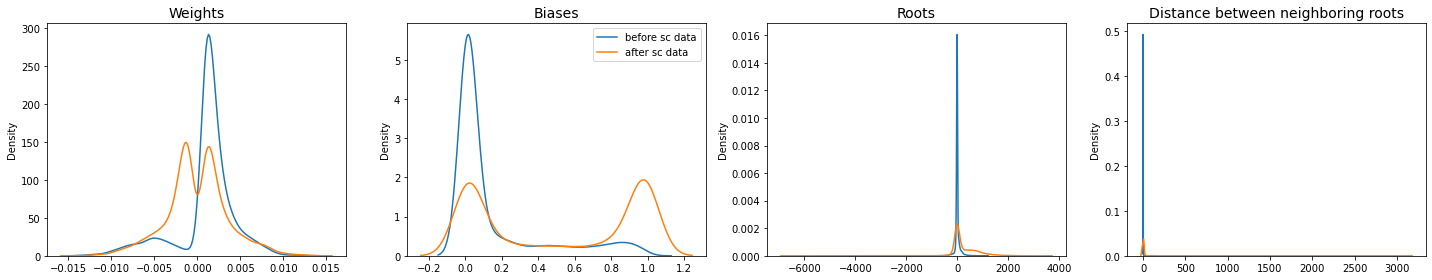

In [374]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].set_title('Weights', fontsize=14)
sns.kdeplot(w_, label='before sc data', ax=axes[0])
sns.kdeplot(w, label='after sc data', ax=axes[0])

axes[1].set_title('Biases', fontsize=14)
sns.kdeplot(b_, label='before sc data', ax=axes[1])
sns.kdeplot(b, label='after sc data', ax=axes[1])

axes[2].set_title('Roots', fontsize=14)
sns.kdeplot(roots_, label='before sc data', ax=axes[2])
sns.kdeplot(roots, label='after sc data', ax=axes[2])

axes[3].set_title('Distance between neighboring roots', fontsize=14)
sns.kdeplot(dist_, label='before sc data', ax=axes[3])
sns.kdeplot(dist, label='after sc data', ax=axes[3])

axes[1].legend()
plt.tight_layout()
plt.show()

**Conclusion:** Number of steps should be at least **10 times higher** than median distance between roots (but no guarantees).

* if left boundary of site > right boundary of search interval, $p \approx 1$
* if right boundary of site < left boundary of search interval, $p \approx 0$

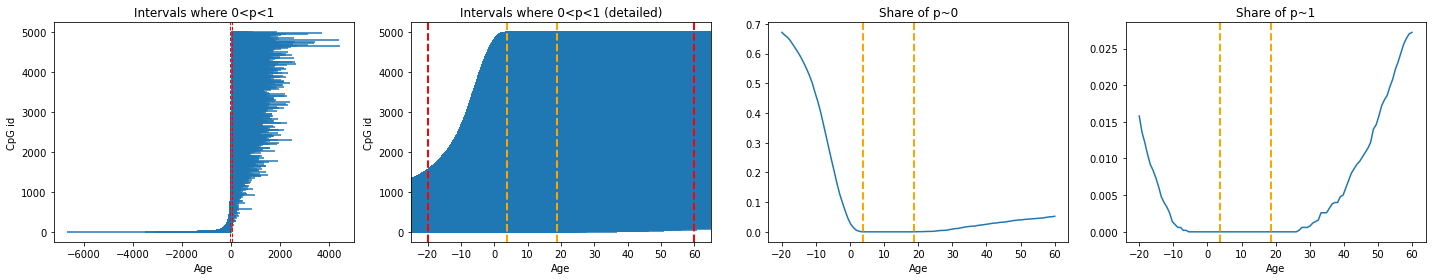

In [375]:
interval_of_search = (-20, 60)
plot_root_intervals(w_, b_, interval_of_search=interval_of_search) #if all CpG are 1

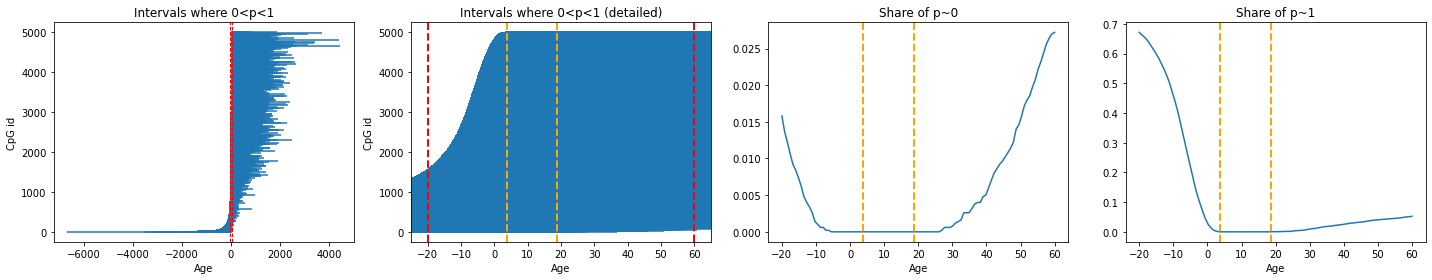

In [376]:
plot_root_intervals(-w_, 1-b_, interval_of_search=interval_of_search) #if all CpG are 0

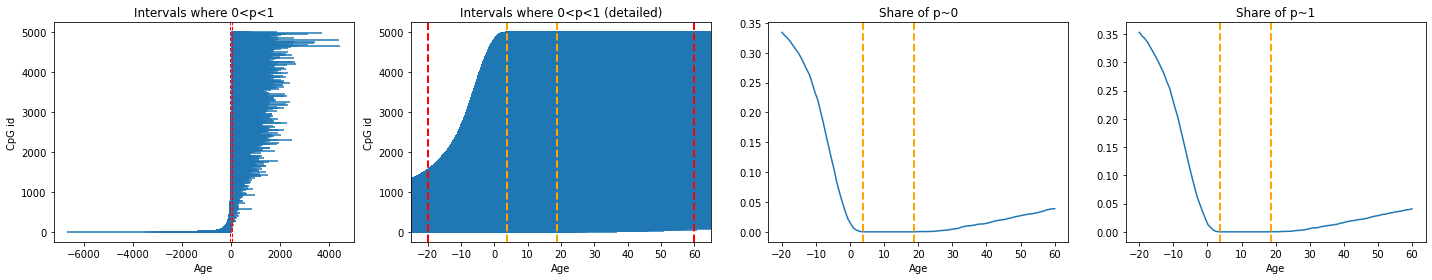

In [377]:
plot_root_intervals(w, b, interval_of_search=interval_of_search) #if half CpG are 0

**Conclusion:** Proper interval should be used, where probabilities don't turn into boundary constants.

In [379]:
n_steps = 1000
m_cells = 100
interval_of_search = (-20, 60)
# eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
# interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
one_met_replacement = 0.999
zero_met_replacement = 0.001

probs = np.zeros((m_cells, n_steps))
x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'p':[]})
for p_met in np.linspace(0, 1.0, 12):
    for cell in range(m_cells):
        mask = np.random.binomial(1, p=p_met, size=top).astype(bool)
        for i, xi in enumerate(x):
            p = w_ * xi + b_
            p[p <= 0] = zero_met_replacement
            p[p >= 1] = one_met_replacement
            p = np.where(mask, p, 1-p)
            probs[cell, i] = np.log(p).sum()

    x_opt = np.array([x[i] for i in np.argmax(probs, axis=1)])
    data = pd.concat([data, pd.DataFrame({'Ages':x_opt, "p":round(p_met, 2)})])

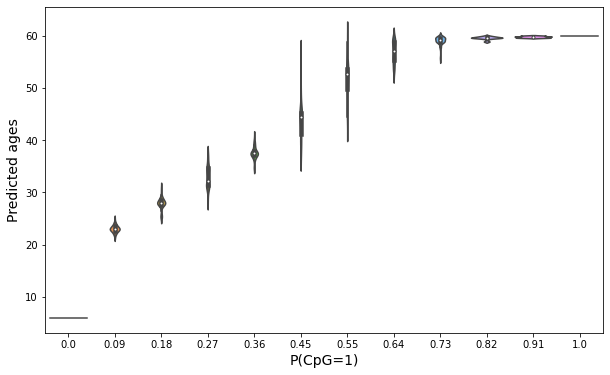

In [380]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.violinplot(x='p', y='Ages', data=data, ax=axes)
axes.set_xlabel('P(CpG=1)', fontsize=14)
axes.set_ylabel('Predicted ages', fontsize=14);

### Real data

Here we reproduce the original procedure and obtain ground truth result.

In [381]:
meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
meta['stage'] = meta['characteristics_ch1.1.developmental stage']
stages = sorted(meta['stage'].unique().tolist())
list_cells = glob('cell_data/cells/*.h5')

######
n_steps = 1000
interval_of_search = (-20, 60) #CUSTOM INTERVAL IN SCOPE
######

x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        ### read data ###
        path = f'cell_data/cells/{cell_name}.h5'
        assert os.path.exists(path)
        cell_df = pd.read_hdf(path)
        
        ### filter data ###
        #coverage check
        if cell_df.shape[0] < 500_000: continue    
        #common sites check
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0: continue
            
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites][cell_name].values
        probs = []
        for i, xi in enumerate(x):
            p = w_ * xi + b_
            p[p <= 0] = zero_met_replacement
            p[p >= 1] = one_met_replacement
            p = np.where(mask, p, 1-p)
            probs.append(np.log(p).sum())
        cell_ages.append(x[np.argmax(probs)])
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(np.mean(cell_df[cell_name]))
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

100%|██████████| 296/296 [01:55<00:00,  2.56it/s]


In [382]:
print(data.groupby('Stage').count().iloc[:, 0])
data.groupby('Stage').mean()

Stage
E4.5     94
E5.5    101
E6.5    145
E7.5    155
Name: Ages, dtype: int64


,Ages,n_sites,p_empiric,p_empiric_full_cell
Stage,,,,
E4.5,8.048474,153.053191,0.070187,0.273517
E5.5,-1.939167,165.990099,0.139623,0.682844
E6.5,-2.771737,239.068966,0.137962,0.745636
E7.5,-5.322613,276.793548,0.120269,0.747040


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

E4.5 v.s. E5.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.375e-09 U_stat=7.116e+03
E5.5 v.s. E6.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.618e+03
E6.5 v.s. E7.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.321e-01 U_stat=1.275e+04


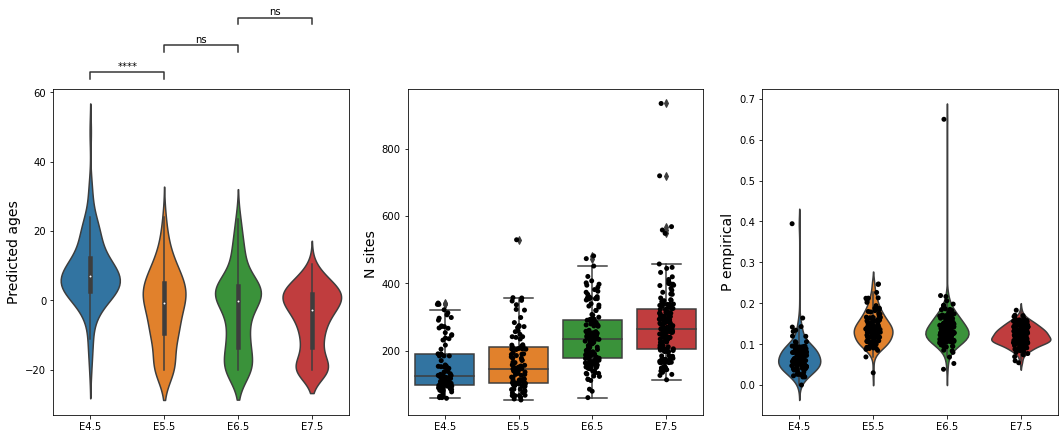

In [383]:
from statannot import add_stat_annotation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
test_results = add_stat_annotation(axes[0], data=data, x='Stage', y='Ages',
                                   box_pairs=[('E4.5', 'E5.5'), 
                                              ('E5.5', 'E6.5'),
                                              ('E6.5', 'E7.5')
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=1)
axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

Now let's change the arbitrary interval with proper one.

In [384]:
meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
meta['stage'] = meta['characteristics_ch1.1.developmental stage']
stages = sorted(meta['stage'].unique().tolist())
list_cells = glob('cell_data/cells/*.h5')

#PROPER INTERVAL IN SCOPE
eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
############

x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        path = f'cell_data/cells/{cell_name}.h5'
        assert os.path.exists(path)
        cell_df = pd.read_hdf(path)
        #coverage check
        if cell_df.shape[0] < 500_000: continue    
        #common sites check
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0:
            continue
        
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites][cell_name].values
        probs = []
        for i, xi in enumerate(x):
            p = w_ * xi + b_
            p[p <= 0] = zero_met_replacement
            p[p >= 1] = one_met_replacement
            p = np.where(mask, p, 1-p)
            probs.append(np.log(p).sum())
        cell_ages.append(x[np.argmax(probs)])
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(np.mean(cell_df[cell_name]))
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

100%|██████████| 296/296 [01:57<00:00,  2.51it/s]


In [385]:
print(data.groupby('Stage').count().iloc[:, 0])
data.groupby('Stage').mean()

Stage
E4.5     94
E5.5    101
E6.5    145
E7.5    155
Name: Ages, dtype: int64


,Ages,n_sites,p_empiric,p_empiric_full_cell
Stage,,,,
E4.5,9.055524,153.053191,0.070187,0.273517
E5.5,4.972643,165.990099,0.139623,0.682844
E6.5,4.790838,239.068966,0.137962,0.745636
E7.5,3.254940,276.793548,0.120269,0.747040


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

E4.5 v.s. E5.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.002e-08 U_stat=6.872e+03
E5.5 v.s. E6.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.686e+03
E6.5 v.s. E7.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.520e-01 U_stat=1.223e+04


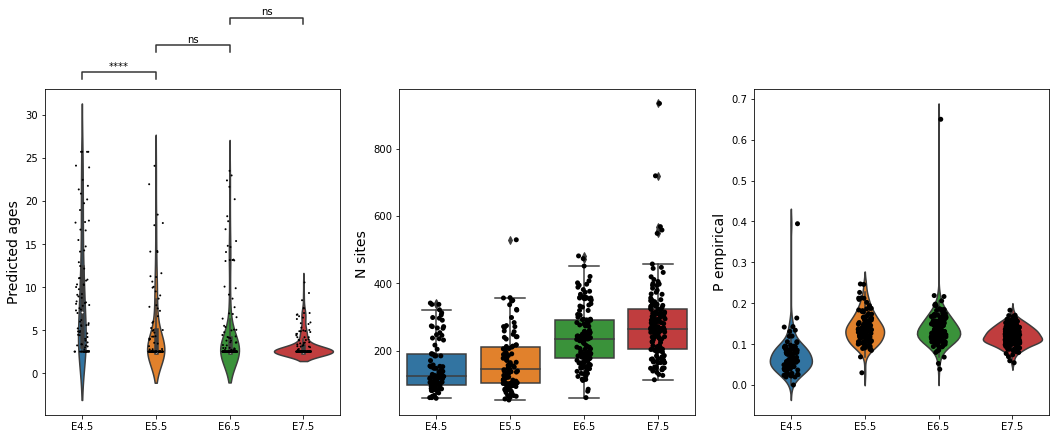

In [387]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
sns.stripplot(x='Stage', y='Ages', data=data, ax=axes[0], color='black', s=2)
test_results = add_stat_annotation(axes[0], data=data, x='Stage', y='Ages',
                                   box_pairs=[('E4.5', 'E5.5'), 
                                              ('E5.5', 'E6.5'),
                                              ('E6.5', 'E7.5')
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=1)
axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

# Correct procedure

### Artificial data

In [413]:
m_cells = 100
w_ = np.asarray(top_sites['Coef'])
b_ = np.asarray(top_sites['Intercept'])

eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
print("Correct interval:", interval_of_search)

data = pd.DataFrame({'Ages':[], 'p':[]})
for p_met in np.linspace(0., 1.0, 12):
    x_opt = np.zeros(m_cells)
    for cell in range(m_cells):
        mask = np.random.binomial(1, p=p_met, size=top).astype(bool)
        w = np.where(mask, w_, -w_)
        b = np.where(mask, b_, 1-b_)
        x_opt[cell] = get_max(w, b, domain=interval_of_search, verbose=0, proper_interval=True)

    data = pd.concat([data, pd.DataFrame({'Ages':x_opt, "p":round(p_met, 2)})])

Correct interval: (2.525556585750008, 25.707286335607854)


/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
/home/shappiron/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
/home/shappiron/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not makin

In [415]:
data

,Ages,p
0,5.957151,0.0
1,5.957151,0.0
2,5.957151,0.0
3,5.957151,0.0
4,5.957151,0.0
...,...,...
95,2.525557,1.0
96,2.525557,1.0
97,2.525557,1.0
98,2.525557,1.0


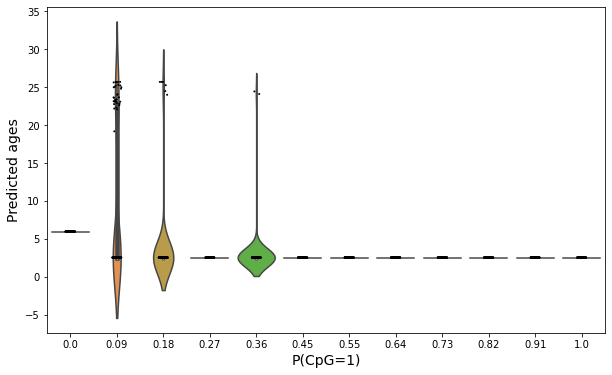

In [414]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.violinplot(x='p', y='Ages', data=data, ax=axes)
sns.stripplot(x='p', y='Ages', data=data, ax=axes, color='black', s=2)
axes.set_xlabel('P(CpG=1)', fontsize=14)
axes.set_ylabel('Predicted ages', fontsize=14);

*Question*: Ground zero in radnom data???

### Real data

In [416]:
meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
meta['stage'] = meta['characteristics_ch1.1.developmental stage']
stages = sorted(meta['stage'].unique().tolist())
list_cells = glob('cell_data/cells/*.h5')

#PROPER INTERVAL IN SCOPE
eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
############

data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        path = f'cell_data/cells/{cell_name}.h5'
        assert os.path.exists(path)
        cell_df = pd.read_hdf(path)
        #coverage check
        if cell_df.shape[0] < 500_000: continue    
        #common sites check
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0:
            continue
        
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites][cell_name].values
        w = np.where(mask, w_, -w_)
        b = np.where(mask, b_, 1-b_)
        predicted_age = get_max(w, b, domain=interval_of_search, verbose=0)
        
        cell_ages.append(predicted_age)
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(np.mean(cell_df[cell_name]))
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

 18%|█▊        | 24/133 [00:12<01:17,  1.41it/s]/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
 20%|█▉        | 26/133 [00:14<01:22,  1.29it/s]/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
 21%|██        | 28/133 [00:16<01:37,  1.08it/s]/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
 24%|██▍       | 32/133 [00:18<00:47,  2.14it/s]/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
 26%|██▌       | 34/133 [00:20<01:05,  1.52it/s]/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) f

In [417]:
data.groupby('Stage').mean()

,Ages,n_sites,p_empiric,p_empiric_full_cell
Stage,,,,
E4.5,11.855237,153.053191,0.070187,0.273517
E5.5,6.845827,165.990099,0.139623,0.682844
E6.5,9.596447,239.068966,0.137962,0.745636
E7.5,8.725912,276.793548,0.120269,0.747040


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

E4.5 v.s. E5.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.485e-07 U_stat=6.758e+03
E5.5 v.s. E6.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.527e-01 U_stat=6.596e+03
E6.5 v.s. E7.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.545e-01 U_stat=1.196e+04


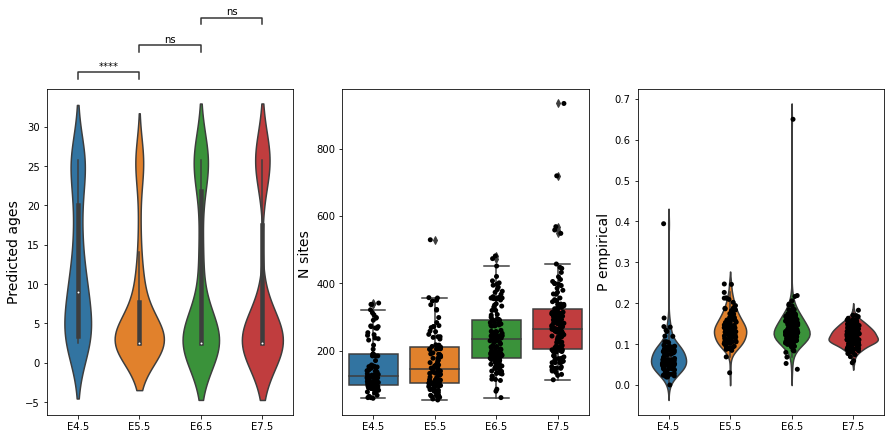

In [418]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
test_results = add_stat_annotation(axes[0], data=data, x='Stage', y='Ages',
                                   box_pairs=[('E4.5', 'E5.5'), 
                                              ('E5.5', 'E6.5'),
                                              ('E6.5', 'E7.5')
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=1)
axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

Conclusion: I see ground zero after my procedure.

# Other

In [408]:
def get_max(w, b, domain=None, verbose=0, proper_interval=True):
    """
    Get maxium of Likelihood by checking each concave part of polynimial
    likelihood separately.
    
    Params:
    w - weights of CpGs from reference data
    b - biases of CpGs from reference data
    domain - interval of search
    verbose - if print the information about whether the solution was on the boundary of the interval
    proper_interval - if domain includes ages where p < 0 or p > 1, then do not use log-likelihood
    and use direct product instead

    Return: optimal age
    """
    roots = -b / w
    ord = 'even' if (len(roots) % 2) == 0 else 'odd'
    sign = np.prod(np.sign(w))
    roots = np.sort(roots)
    domain = [roots[0], roots[-1]] if domain is None else domain

    if proper_interval:
        ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
    else:
        ff = lambda x: np.prod([(wi*x + bi) for wi, bi in zip(w, b)])
    df = lambda x: np.sum([wi/(wi*x + bi) for wi, bi in zip(w, b)])

    if (ord == 'even') and (sign > 0): #first root left from min; last root right from min
        pairs = roots[1:-1].reshape(-1, 2).tolist()
    elif (ord == 'even') and (sign < 0): #first root left from max; last root right from max
        pairs = roots.reshape(-1, 2).tolist()
    elif (ord == 'odd') and (sign > 0): #first root left from max; last root right from min
        pairs = roots[:-1].reshape(-1, 2).tolist()
    elif (ord == 'odd') and (sign < 0): #first root left from min; last root right from max
        pairs = roots[1:].reshape(-1, 2).tolist()
        
    maxroots = []
    for pair in pairs:
        #if (pair[1] < domain[0]) or (pair[0] > domain[1]): continue
        if pd.Interval(*domain).overlaps(pd.Interval(*pair)):
            root = fsolve(df, np.mean(pair))[0]
            #print(root)
        else:
            continue
        if (domain[0] <= root <= domain[1]): #maximum must be within the interval
            maxroots.append(root)
    
    maxroots = [domain[0]] + maxroots + [domain[1]] # check interval boundaries
    solution = maxroots[np.argmax([ff(m) for m in maxroots])]
    if verbose > 0:
        if (solution == maxroots[0]):
            print('Solution on the start of the interval!')
        elif solution == maxroots[-1]:
            print('Solution on the end of the interval!')
        else:
            pass
    return solution

10.57889732054429
My procedure: 10.57889732054429
Numerically: []

23.74929954685503
23.74929954685503
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


27.29421186522698
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


41.928166788089875
26.042613090061046
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


40.043680156470465
My procedure: 24
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


25.353233896195707
28.651064042266206
29.616696003031034
46.35929293724842
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


29.335322697402635
56.35650050315699
25.11260210183885
31.743510013575882
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


35.70418544803957
29.630896585476183
26.49870861067009
27.186483783278618
21.43770466804567
28.657757769645688
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


3.034921435761842
48.63261020108766
28.655992799677605
50.45302479311479
24.148168912558187
25.493788854649583
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


22.567206038352257


/home/shappiron/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


19.324633380097886
26.25091914330102
30.345010683159284
22.141297761612996
24.143509453069623
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
/home/shappiron/anaconda3/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


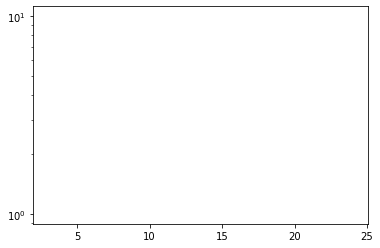

In [405]:
from scipy.signal import argrelextrema

n = 5000 #number of weights
after_data = True
top_idx = clocks['PearsonR'].abs().sort_values(ascending=False)[:n].index
top_sites_test = clocks.loc[top_idx]

interval_of_search = (3, 24)
w_ = np.asarray(top_sites_test['Coef'])
b_ = np.asarray(top_sites_test['Intercept'])

for p_nonmet in np.arange(0.01, 1.0, 0.1):
    if after_data:
        # make an artificial signle cell methylation data (sampled from binomial distribution)
        p_nonmet = p_nonmet
        mask = np.random.binomial(1, p=p_nonmet, size=n).astype(bool)

        #change weights and biases based on 0 or 1 in methylation data (apply -1 if 0)
        # w = np.array([-wi if m==False else wi for m, wi in zip(mask, w_)])
        # b = np.array([1-bi if m==False else bi for m, bi in zip(mask, b_)])
        w = np.where(mask, w_, -w_)
        b = np.where(mask, b_, 1-b_)
        roots = -b / w #polynomial roots after single cell data
        dist = np.diff(np.sort(roots))
    else: 
        w = w_.copy()
        b = b_.copy()

    ff = lambda x: np.prod([(wi_*x + bi_) for wi_, bi_ in zip(w, b)])
    z = np.linspace(interval_of_search[0], interval_of_search[1], 1000)
    fz = [ff(zi) for zi in z]


    extrema = argrelextrema(np.array(fz), np.greater, mode='wrap')[0]
    num_max = z[extrema]
    num_max = [z[0], num_max, z[-1]][np.argmax([ff(z[0]), ff(num_max), ff(z[-1])])] #include boundaries

    print("My procedure:", get_max(w, b, domain=interval_of_search, proper_interval=True))
    print("Numerically:", num_max)
    print()

    plt.semilogy(z, fz);